To use C++ code in python, we have to build a class in C++ and then export it as a library that python can read. [This](https://www.auctoris.co.uk/2017/04/29/calling-c-classes-from-python-with-ctypes/) article makes that library.so and then uses ctypes when calling the class and passing it variables in python. [This](https://iq.opengenus.org/create-shared-library-in-cpp/) article has an alternate way of creating the library that is much simpler.

The way I structures this notebook to do soccer analysis is to write the file in a code cell here, then import it from the following code cell (stored in Drive). The class takes in 4 variables upon creation: home and away team atk and def ratings. Upon construction, the class calculates home and away win percentages, which can each be returned with a function call.

To test this, I can use values from the World Cup simulator, which will make the declarations in python trivial and avoid a significant amount of data manipulation.

In [ ]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

In [ ]:
%%writefile CalcWinPercentage.cpp

#include <iostream>
#include <cstring>
#include <cstdlib>
#include <string>
#include <cmath>

using namespace std;

class CalcWinPercentage {
    public:
        CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void calc(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void reset() {
            homewin = 0.0;
            awaywin = 0.0;
        }
        double homewinpercentage() {return homewin;}
        double awaywinpercentage() {return awaywin;}
        int factorial (int num);
        
        const float avgGoals = 1.56;
 
    private:
        double homewin, awaywin;
};

CalcWinPercentage::CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    homewin = 0;
    awaywin = 0;

    int i, j;
    float scoreChance, homeExpGoals, awayExpGoals;
 
    // this is broken because the formula is based on percentages, so 1 - x is positive
    homeExpGoals = ((homeAtk * awayDef) / avgGoals) / ((homeAtk * awayDef) / avgGoals + (avgGoals/ (homeAtk * awayDef)));
    awayExpGoals = ((awayAtk * homeDef) / avgGoals) / ((awayAtk * homeDef) / avgGoals + ((1 - awayAtk) * (1 - homeDef) / (1 - avgGoals)));
 
    for (i = 0; i < 8; i++) {
        for (j = 0; j < 8; j++) {
            scoreChance = pow(homeExpGoals, i) * pow(awayExpGoals, j) * exp(-(homeExpGoals + awayExpGoals)) / (factorial(i) * factorial(j));
            if (i > j) {
                homewin += scoreChance;
            }
            if (j > i) {
                awaywin += scoreChance;
            }
        }
    }

    homewin = homeExpGoals;
    awaywin = awayExpGoals;
}

void CalcWinPercentage::calc(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    int i, j;
    float scoreChance;
    homewin = 0;
    awaywin = 4.5;
 
}

int CalcWinPercentage::factorial (int num) {
    int result = 1;
    if (num > 0) {
        for (int i = num; i > 1; i--) {
            result *= i;
        }
    }
    return result;
}

// Define C functions for the C++ class that can be accessed by ctypes

extern "C"
{
    CalcWinPercentage* CWP_new(double ha, double hd, double aa, double ad) {return new CalcWinPercentage(ha, hd, aa, ad);}
    void CWP_calc(CalcWinPercentage* cwp, double ha, double hd, double aa, double ad) {cwp->calc(ha, hd, aa, ad);}
    void CWP_reset(CalcWinPercentage* cwp) {cwp->reset();}
    double CWP_homewinpercentage(CalcWinPercentage* cwp) {return cwp->homewinpercentage();}
    double CWP_awaywinpercentage(CalcWinPercentage* cwp) {return cwp->awaywinpercentage();}
    int CWP_factorial(CalcWinPercentage* cwp, int num) {return cwp->factorial(num);}
}

Writing CalcWinPercentage.cpp


In [ ]:
!rm libCalcWinPercentage.so
!rm CalcWinPercentage.o
!ls -l

rm: cannot remove 'libCalcWinPercentage.so': No such file or directory
rm: cannot remove 'CalcWinPercentage.o': No such file or directory
total 12
-rw-r--r-- 1 root root 2649 Jul 10 03:14 CalcWinPercentage.cpp
drwx------ 5 root root 4096 Jul 10 03:08 drive
drwxr-xr-x 1 root root 4096 Jul  6 13:22 sample_data


In [ ]:
!g++ -c -fPIC CalcWinPercentage.cpp -o CalcWinPercentage.o
!gcc -shared -o libCalcWinPercentage.so CalcWinPercentage.o
!ls -l

total 36
-rw-r--r-- 1 root root  2660 Jul 20 01:18 CalcWinPercentage.cpp
-rw-r--r-- 1 root root  7952 Jul 20 01:19 CalcWinPercentage.o
drwx------ 5 root root  4096 Jul 20 01:18 drive
-rwxr-xr-x 1 root root 13608 Jul 20 01:19 libCalcWinPercentage.so
drwxr-xr-x 1 root root  4096 Jul 13 13:43 sample_data


In [ ]:
import ctypes
import numpy as np
import pandas as pd

lib = ctypes.cdll.LoadLibrary('/content/libCalcWinPercentage.so')

class CalcWinPercentage:
  def __init__(self, ha, hd, aa, ad):
    lib.CWP_new.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_new.restype = ctypes.c_void_p

    lib.CWP_calc.argtypes = [ctypes.c_void_p, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_calc.restype = ctypes.c_void_p

    lib.CWP_reset.argtypes = [ctypes.c_void_p]
    lib.CWP_reset.restype = ctypes.c_void_p

    lib.CWP_homewinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_homewinpercentage.restype = ctypes.c_double

    lib.CWP_awaywinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_awaywinpercentage.restype = ctypes.c_double

    lib.CWP_factorial.argtypes = [ctypes.c_void_p, ctypes.c_int]
    lib.CWP_factorial.restype = ctypes.c_int

    self.obj = lib.CWP_new(ha, hd, aa, ad)

  def calc(self, ha, hd, aa, ad):
    lib.CWP_calc(self.obj, ha, hd, aa, ad)

  def reset(self):
    lib.CWP_reset(self.obj)

  def homewinpercentage(self):
    return lib.CWP_homewinpercentage(self.obj)

  def awaywinpercentage(self):
    return lib.CWP_awaywinpercentage(self.obj)

# from lib import CalcWinPercentage

# Test that the C++ library is working

cwp = CalcWinPercentage(4, 5, 6.7, 7)
print(cwp.awaywinpercentage())
print(cwp.homewinpercentage())
cwp.reset()
print(cwp.awaywinpercentage())

In [4]:
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime

global game_data, spi_matches_league
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')

def LaLiga(temp):
  global game_data, spi_matches_league
  output.clear_output()
  now = datetime.now()
  with output:
    print('Start running La Liga at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/La Liga.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_La_Liga.csv')
  now = datetime.now()
  with output:
    print("La Liga processed at: ", now)

def Bundesliga(temp):
  global game_data, spi_matches_league
  output.clear_output()
  now = datetime.now()
  with output:
    print('Start running Bundesliga at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/Bundesliga.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_Bundesliga.csv')
  now = datetime.now()
  with output:
    print("Bundesliga processed at: ", now)

def EPL(temp):
  global game_data, spi_matches_league
  output.clear_output()
  now = datetime.now()
  with output:
    print('Start running EPL at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/EPL.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_EPL.csv')
  now = datetime.now()
  with output:
    print("EPL processed at: ", now)

def Eredivisie(temp):
  global game_data, spi_matches_league
  output.clear_output()
  now = datetime.now()
  with output:
    print('Start running Eredivisie at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/Eredivisie.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_Eredivisie.csv')
  now = datetime.now()
  with output:
    print("Eredivisie processed at: ", now)

# Build widgets for running the model
output = widgets.Output()
tab_contents = ['League Data', 'Build Model', 'Input Test Data', 'Data Visualizations']
league_names = ['EPL', 'LaLiga', 'Bundesliga', 'Eredivisie']
children = [widgets.Button(description=name, disabled=False) for name in league_names]
build = widgets.Button(description='Build', disabled=False)
tb_hometeam = widgets.Text(description='Home Team', disabled=False)
tb_awayteam = widgets.Text(description='Away Team', disabled=False)
tb_draw = widgets.Text(description='Draw', disabled=True)
left_box = widgets.VBox([tb_hometeam, tb_awayteam, tb_draw])
tb_homeodds = widgets.Text(description='Home Odds', disabled=False)
tb_awayodds = widgets.Text(description='Away Odds', disabled=False)
tb_drawodds = widgets.Text(description='Draw Odds', disabled=False)
right_box = widgets.VBox([tb_homeodds, tb_awayodds, tb_drawodds])
tab_input = widgets.HBox([left_box, right_box])
data_viz = widgets.RadioButtons(description='Viz Content', options=['PDF', 'Scatter', 'Combo'], value='PDF', disabled=False)
tab = widgets.Tab()
tab_league = widgets.Box(children)
for x in range(len(league_names)):
  tab_league.children[x].on_click(eval(league_names[x]))
for i in range(len(tab_contents)):
  tab.set_title(i, tab_contents[i])
tab.children = [tab_league, build, tab_input, data_viz]
display(tab, output)

Output()


Gamma distribution correlation
0.5983384420368874
0.5264849560603225

SPI correlation
0.572420356103732
0.5475360586783062

League Average Goals Scored
1.5670098039215685
1.2929575163398692

Gamma pythagorean correlation
0.5951854592063909
Draw stats
18
61
0.2533571199707099
r^2:  0.4076195845644358
corr:  0.7108300979686666
Home stats
4
41
0.4656761514952127
r^2:  0.8960570791022526
corr:  0.9018466773139722
Away stats
52
76
0.3168346865594453
r^2:  0.8123429118678973
corr:  0.9053632304704181

League Average Goals Predicted - Gamma
1.5312633318252091
1.5887666666666667
1.2186183222802
1.2344333333333335

Theory home and away goals, with correlation to xG
0.5386696513507068
1.5331468531468533
0.5256290756352812
1.3677272727272727

Gamma Pythag vs Sample Pythag
0.5977202454846234
0.5771195207760822


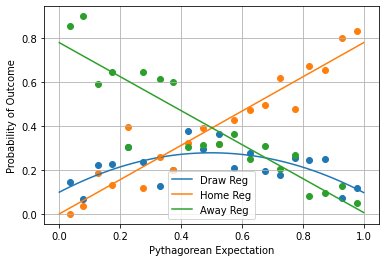

In [73]:
# This cell creates initial xG projections
from sklearn.metrics import r2_score

sample_data = game_data[game_data['Season'] < 2021]
test_data = game_data[game_data['Season'] >= 2021].reset_index(drop=True)
sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]

gld_home = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_away = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_home.fit(sample_home, np.array(sample_data['Home Goals']))
gld_away.fit(sample_away, np.array(sample_data['Away Goals']))

pred_home = [[test_data['Home Atk'][x], test_data['Away Def'][x]] for x in range(len(test_data))]
pred_away = [[test_data['Away Atk'][x], test_data['Home Def'][x]] for x in range(len(test_data))]
model_xg_home = gld_home.predict(pred_home)
model_xg_away = gld_away.predict(pred_away)
             
test_data['Gamma Pred Home'] = np.array(model_xg_home)
test_data['Gamma Pred Away'] = np.array(model_xg_away)
test_data['Gamma Pred Pythag'] = np.divide(np.multiply(model_xg_home, model_xg_home), np.add(np.multiply(model_xg_home, model_xg_home), np.multiply(model_xg_away, model_xg_away)))

poly_data = spi_matches_league[spi_matches_league['season'] < 2021]
poly_data = poly_data[poly_data['score1'].notna()]
poly_data = poly_data[poly_data['proj_score1'].notna()]
poly_data['result'] = np.array(poly_data['score1']) - np.array(poly_data['score2'])
proj_score1 = np.array(poly_data['proj_score1'])
proj_score2 = np.array(poly_data['proj_score2'])
proj_pythag = np.divide(np.multiply(proj_score1, proj_score1), np.add(np.multiply(proj_score1, proj_score1), np.multiply(proj_score2, proj_score2)))
poly_data['pythag'] = proj_pythag
poly_data = poly_data.sort_values(['pythag']).reset_index(drop=True)
bin_size = np.linspace(0, 1, 21)
bin_indices = [len(poly_data[poly_data['pythag'] < x]) for x in bin_size]
bins = [poly_data.iloc[bin_indices[x]:bin_indices[x+1]] for x in range(len(bin_indices) - 1)]
avg_pythag = [bin['pythag'].mean() for bin in bins]
draw_percent = [len(bin[bin['result'] == 0]) / len(bin) for bin in bins]
home_percent = [len(bin[bin['result'] > 0]) / len(bin) for bin in bins]
away_percent = [len(bin[bin['result'] < 0]) / len(bin) for bin in bins]

draw_reg = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, draw_percent, 2).convert().coef)
proj_draws = [draw_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
test_data['Draw Prob'] = np.array(proj_draws)
pred_draws = [draw_reg(a) for a in avg_pythag]

home_reg = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, home_percent, 1).convert().coef)
proj_home = [home_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
test_data['Home Prob'] = np.array(proj_home)
pred_home = [home_reg(a) for a in avg_pythag]

away_reg = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, away_percent, 1).convert().coef)
proj_away = [away_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
test_data['Away Prob'] = np.array(proj_away)
pred_away = [away_reg(a) for a in avg_pythag]

print("\nGamma distribution correlation")
print(test_data['Gamma Pred Home'].corr(test_data['Home Goals']))
print(test_data['Gamma Pred Away'].corr(test_data['Away Goals']))

print("\nSPI correlation")
print(spi_matches_league['proj_score1'].corr(spi_matches_league['xg1']))
print(spi_matches_league['proj_score2'].corr(spi_matches_league['xg2']))

print("\nLeague Average Goals Scored")
print(spi_matches_league['xg1'].mean())
print(spi_matches_league['xg2'].mean())

print("\nGamma pythagorean correlation")
print(test_data['Gamma Pred Pythag'].corr(test_data['Pythag']))
print('Draw stats')
print(len(test_data[test_data['Draw Prob'] < .2]))
print(len(test_data[test_data['Draw Odds'] < .2]))
print(test_data['Draw Prob'].mean())
print('r^2: ', r2_score(draw_percent, pred_draws))
print('corr: ', test_data['Draw Prob'].corr(test_data['Draw Odds']))
print('Home stats')
print(len(test_data[test_data['Home Prob'] < .2]))
print(len(test_data[test_data['Home Odds'] < .2]))
print(test_data['Home Prob'].mean())
print('r^2: ', r2_score(home_percent, pred_home))
print('corr: ', test_data['Home Prob'].corr(test_data['Home Odds']))
print('Away stats')
print(len(test_data[test_data['Away Prob'] < .2]))
print(len(test_data[test_data['Away Odds'] < .2]))
print(test_data['Away Prob'].mean())
print('r^2: ', r2_score(away_percent, pred_away))
print('corr: ', test_data['Away Prob'].corr(test_data['Away Odds']))

print('\nLeague Average Goals Predicted - Gamma')
print(test_data['Gamma Pred Home'].mean())
print(test_data['Home Goals'].mean())
print(test_data['Gamma Pred Away'].mean())
print(test_data['Away Goals'].mean())
print('\nTheory home and away goals, with correlation to xG')
theory_home = np.array(test_data['Gamma Pred Pythag']) - test_data['Gamma Pred Pythag'].mean()
theory_home = (1.0 + theory_home) * (sample_data['Home Goals'].mean())
print(test_data['Home Goals'].corr(pd.Series(theory_home)))
print(theory_home.mean())

theory_away = test_data['Gamma Pred Pythag'].mean() - np.array(test_data['Gamma Pred Pythag'])
theory_away = (1.0 + theory_away) * (sample_data['Away Goals'].mean())
print(test_data['Away Goals'].corr(pd.Series(theory_away)))
print(theory_away.mean())
print('\nGamma Pythag vs Sample Pythag')
print(test_data['Gamma Pred Pythag'].mean())
print(test_data['Pythag'].mean())

myspace = np.linspace(0, 1, 100)
plt.plot(myspace, draw_reg(myspace), label='Draw Reg')
plt.plot(myspace, home_reg(myspace), label='Home Reg')
plt.plot(myspace, away_reg(myspace), label='Away Reg')
plt.scatter(avg_pythag, draw_percent)
plt.scatter(avg_pythag, home_percent)
plt.scatter(avg_pythag, away_percent)
plt.grid(visible=True)
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Probability of Outcome')
plt.legend()
plt.show()

test_data['Theory_home'] = np.array(theory_home)
test_data['Theory_away'] = np.array(theory_away)

In [74]:
import scipy.integrate as integrate

def CalcIntegral(a, b, constraints_home, constraints_away):
  mean = (a + b) / 2
  result_home = integrate.quad(lambda x: gamma.pdf(x, constraints_home[0], loc=constraints_home[1], scale=constraints_home[2]), a, b)
  result_away = integrate.quad(lambda x: gamma.pdf(x, constraints_away[0], loc=constraints_away[1], scale=constraints_away[2]), a, b)
  return [mean, result_home[0], result_away[0]]

n = 75
neigh_home = NearestNeighbors(n_neighbors=n)
neigh_away = NearestNeighbors(n_neighbors=n)
sample_data = spi_matches_league[spi_matches_league['season'] < 2021]
sample_data = sample_data.dropna()
sample_data = sample_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

knn_sample_home = [[sample_data['proj_score1'].iloc[x]] for x in range(len(sample_data))]
knn_sample_away = [[sample_data['proj_score2'].iloc[x]] for x in range(len(sample_data))]
neigh_home.fit(knn_sample_home)
neigh_away.fit(knn_sample_away)

knn_result_home = [neigh_home.kneighbors([[test_data['Theory_home'][x]]]) for x in range(len(test_data))]
knn_result_away = [neigh_away.kneighbors([[test_data['Theory_away'][x]]]) for x in range(len(test_data))]

# A note about the the format of the returned data from kNN.kneighbors
# it is returned as a 4 dimensional array
# the first dimension is index of the element from test_data
# the second is 0 for an array containing the distances of the test data to sample neighbors
# or 1 for an array of indices of neighbors in the sample data
# the third is empty and therefore always 0; this results from the nested structure of the input data
# the fourth is an individual distance or index of a neighbor of the sample data

indices_home = [knn_result_home[x][1][0] for x in range(len(knn_result_home))]
indices_away = [knn_result_away[x][1][0] for x in range(len(knn_result_away))]

integral_values = np.empty([len(test_data), 499, 3])

a = np.linspace(0, 8, 500)
r1 = range(len(indices_home))
r2 = range(len(a) - 1)
for x in r1:
  gamma_sample_home = [sample_data['xg1'].iloc[indices_home[x][z]] for z in range(n)]
  gamma_sample_away = [sample_data['xg2'].iloc[indices_away[x][z]] for z in range(n)]
  
  # constraints are the [0] shape parameter, [1] loc parameter, [2] scale parameter
  constraints_home = gamma.fit(gamma_sample_home)
  constraints_away = gamma.fit(gamma_sample_away)
  for i in r2:
    integral_values[x][i] = CalcIntegral(a[i], a[i+1], constraints_home, constraints_away)


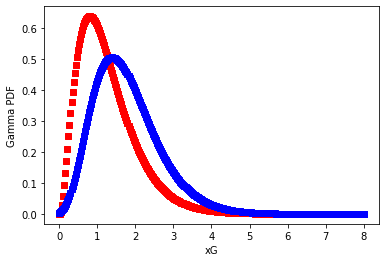

Season                    2021
Date                2021-11-20
Home Team        Wolverhampton
Away Team      West Ham United
Home Goals                1.44
Away Goals                0.42
Home Atk                 1.383
Home Def               1.18575
Away Atk               1.93075
Away Def               1.38025
Theory_home           1.249675
Theory_away           1.559906
Name: 377, dtype: object


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

y = x
buckets = np.linspace(0, 8, num=300)
pdf_buckets_home = [gamma.pdf(buckets[x], constraints_home[0], constraints_home[1], constraints_home[2]) for x in range(len(buckets))]
pdf_buckets_away = [gamma.pdf(buckets[x], constraints_away[0], constraints_away[1], constraints_away[2]) for x in range(len(buckets))]
plt.scatter(buckets, pdf_buckets_home, c='red', marker='s')
plt.scatter(buckets, pdf_buckets_away, c='blue', marker='s')
plt.xlabel('xG')
plt.ylabel('Gamma PDF')
plt.show()
disp_cols = ['Season', 'Date', 'Home Team', 'Away Team', 'Home Goals', 'Away Goals', 'Home Atk', 'Home Def', 'Away Atk', 'Away Def', 'Theory_home', 'Theory_away']
print(test_data[disp_cols].iloc[y])

In [75]:
import random as rand

r1 = range(len(test_data))
r2 = range(len(a) - 1)
odds = np.empty([len(test_data), 3])
for i in r1:
  home_odds = 0
  away_odds = 0
  draw_odds = 0
  for j in r2:
    for k in r2:
      if (abs(integral_values[i][j][0] - integral_values[i][k][0]) < .325):
        draw_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif rand.random() < .025:
        draw_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif (integral_values[i][j][0] > integral_values[i][k][0]):
        home_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif (integral_values[i][k][0] > integral_values[i][j][0]):
        away_odds += (integral_values[i][j][1] * integral_values[i][k][2])
  odds[i] = [home_odds, away_odds, draw_odds]

In [77]:
def CalcBet(df, x):
    threshold = .15
    if df['Draw Edge'].iloc[x] > (threshold):
        return 'D'
    max_edge = max(df['Home Edge'].iloc[x], df['Away Edge'].iloc[x])
    if max_edge < threshold:
        return 'No Bet'
    elif max_edge == df['Home Edge'].iloc[x]:
        return 'H'
    else:
        return 'A'
    
def CalcProfit(df, x):
    if df['Model Bet'].iloc[x] == 'No Bet':
        return 0
    elif df['Model Bet'].iloc[x] == df['Result'].iloc[x]:
        if df['Model Bet'].iloc[x] == 'H':
            return (1/df['Home Odds'].iloc[x] - 1)
        elif df['Model Bet'].iloc[x] == 'A':
            return (1/df['Away Odds'].iloc[x] - 1)
        else:
            return (1/df['Draw Odds'].iloc[x] - 1)
    else:
        return -1

# These rely on integrating slices of the PDF function
test_data['Home Prob'] = [odds[x][0] for x in range(len(odds))]
test_data['Away Prob'] = [odds[x][1] for x in range(len(odds))]
test_data['Draw Prob'] = [odds[x][2] for x in range(len(odds))]
test_data['Home Edge'] = [test_data['Home Prob'][x] - test_data['Home Odds'][x] for x in range(len(test_data))]
test_data['Away Edge'] = [test_data['Away Prob'][x] - test_data['Away Odds'][x] for x in range(len(test_data))]
test_data['Draw Edge'] = [test_data['Draw Prob'][x] - test_data['Draw Odds'][x] for x in range(len(test_data))]
test_data['Model Bet'] = [CalcBet(test_data, x) for x in range(len(test_data))]
test_data['Profit'] = [CalcProfit(test_data, x) for x in range(len(test_data))]

print('Total Profit: ', test_data['Profit'].sum(), ' on ', len(test_data[test_data['Model Bet'] != 'No Bet']), ' total bets')
print(test_data.loc[test_data['Model Bet'] == 'H', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'H']), ' H bets')
print(test_data.loc[test_data['Model Bet'] == 'A', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'A']), ' A bets')
print(test_data.loc[test_data['Model Bet'] == 'D', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'D']), ' D bets')

print('\nTotal games in the dataset: ', len(test_data))
print('Total games in the sample: ', len(sample_data))
print('\nAverage draw probability: ', test_data['Draw Prob'].mean())
print('Percentage of games drawn: ', len(test_data[test_data['Result'] == 'D']) / len(test_data))
print('Average implied probability of a draw: ', test_data['Draw Odds'].mean())

print('\nAverage home win probability: ', test_data['Home Prob'].mean())
print('Percentage of games won by home team: ', len(test_data[test_data['Result'] == 'H']) / len(test_data))
print('Average implied probability: ', test_data['Home Odds'].mean())

print('\nAverage away win probability: ', test_data['Away Prob'].mean())
print('Percentage of games won by away team: ', len(test_data[test_data['Result'] == 'A']) / len(test_data))
print('Average implied probability: ', test_data['Away Odds'].mean())

print('\nTotal Hold: ', (test_data['Draw Odds'].mean() + test_data['Home Odds'].mean() + test_data['Away Odds'].mean()))
print('Total projected probability: ', (test_data['Draw Prob'].mean() + test_data['Home Prob'].mean() + test_data['Away Prob'].mean()))
print('\nPythag ratios')
print(test_data['Pythag'].mean())
print((len(test_data[test_data['Result'] == 'H']) + .5 * len(test_data[test_data['Result'] == 'D'])) / len(test_data))
print(1 - test_data['Pythag'].mean())
print((len(test_data[test_data['Result'] == 'A']) + .5 * len(test_data[test_data['Result'] == 'D'])) / len(test_data))

print('\nCorrelation between projected outcome probability and odds')
print('Home win: ', test_data['Home Prob'].corr(test_data['Home Odds']))
print('Away win: ', test_data['Away Prob'].corr(test_data['Away Odds']))
print('Draw: ', test_data['Draw Prob'].corr(test_data['Draw Odds']))


Total Profit:  14.550000000000008  on  24  total bets
Profit   -1.0
dtype: float64  on  1  H bets
Profit    15.55
dtype: float64  on  23  A bets
Profit    0.0
dtype: float64  on  0  D bets

Total games in the dataset:  300
Total games in the sample:  306

Average draw probability:  0.2479170548400609
Percentage of games drawn:  0.21333333333333335
Average implied probability of a draw:  0.24457708738789383

Average home win probability:  0.3777197851081419
Percentage of games won by home team:  0.4266666666666667
Average implied probability:  0.471072391554087

Average away win probability:  0.37231885555284855
Percentage of games won by away team:  0.36
Average implied probability:  0.3467063341896335

Total Hold:  1.0623558131316142
Total projected probability:  0.9979556955010513

Pythag ratios
0.5771195207760822
0.5333333333333333
0.4228804792239178
0.4666666666666667

Correlation between projected outcome probability and odds
Home win:  0.8831152561365484
Away win:  0.895014643588

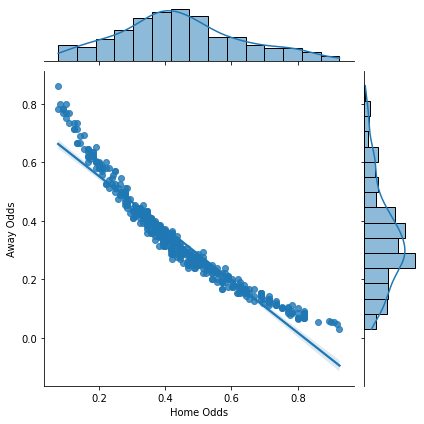

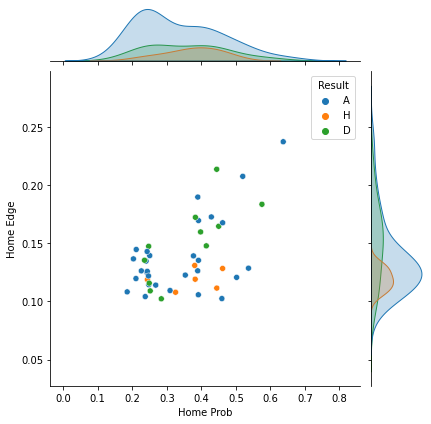

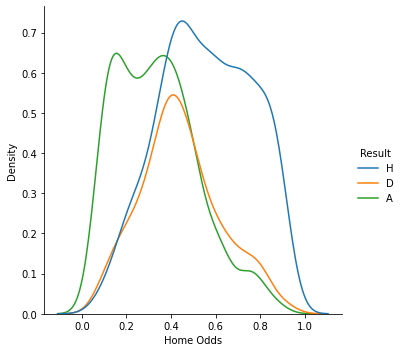

In [49]:
import seaborn as sns

sns.jointplot(data=game_data[game_data['Result'] == 'D'], x='Home Odds', y='Away Odds', kind='reg')

sns.jointplot(data=test_data[test_data['Model Bet'] == 'H'], x='Home Prob', y='Home Edge', hue='Result')
#sns.jointplot(data=test_data[test_data['Result'] == 'A'], x='Away Prob', y='Away Odds', hue='Model Bet')
#sns.jointplot(data=test_data[test_data['Result'] == 'D'], x='Draw Prob', y='Draw Odds', hue='Model Bet')

# These display the distribution of projected draws from me and SPI as a check; they should have similar shape
sns.displot(game_data, x='Home Odds', hue='Result', kind='kde')
#sns.displot(test_data['Draw Odds'])
#sns.displot(spi_matches_league['probtie'])

UEFA Champions League  regression:  0.11018687200616153 + 0.7114374495280102·x¹ - 0.6897928209600441·x²
UEFA Champions League  r^2:  0.328559653006412
Sample size:  744
Average goals scored per game:  3.063172043010753
 
UEFA Europa Conference League  regression:  0.11018687200616153 + 0.7114374495280102·x¹ - 0.6897928209600441·x²
UEFA Europa Conference League  r^2:  0.3877623582384935
Sample size:  141
Average goals scored per game:  2.8652482269503547
 
Scottish Premiership  regression:  0.11018687200616153 + 0.7114374495280102·x¹ - 0.6897928209600441·x²
Scottish Premiership  r^2:  0.3419494973557953
Sample size:  1085
Average goals scored per game:  2.5483870967741935
 
Barclays Premier League  regression:  0.11018687200616153 + 0.7114374495280102·x¹ - 0.6897928209600441·x²
Barclays Premier League  r^2:  0.6184571398616385
Sample size:  2280
Average goals scored per game:  2.7557017543859645
 
FA Women's Super League  regression:  0.11018687200616153 + 0.7114374495280102·x¹ - 0.6897

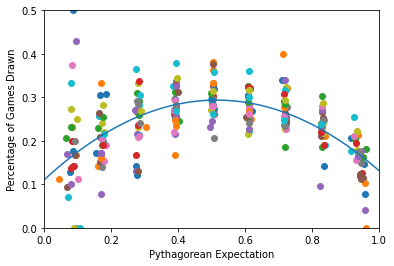

In [93]:
# score1 and score2 represent the actual score of the game
from sklearn.metrics import r2_score
spi_matches = spi_matches[spi_matches['score1'].notna()]
spi_matches = spi_matches[spi_matches['proj_score1'].notna()]
spi_matches['result'] = np.array(spi_matches['score1']) - np.array(spi_matches['score2'])
spi_matches = spi_matches.sort_values(['prob1']).reset_index(drop=True)
proj_score1 = np.array(spi_matches['proj_score1'])
proj_score2 = np.array(spi_matches['proj_score2'])
proj_pythag = np.divide(np.multiply(proj_score1, proj_score1), np.add(np.multiply(proj_score1, proj_score1), np.multiply(proj_score2, proj_score2)))
spi_matches['pythag'] = proj_pythag
spi_matches = spi_matches.sort_values(['pythag']).reset_index(drop=True)

bin_size = np.linspace(0, 1, 50)
bin_indices = [len(spi_matches[spi_matches['pythag'] < x]) for x in bin_size]
bins = [spi_matches.iloc[bin_indices[x]:bin_indices[x+1]] for x in range(len(bin_indices) - 1)]
avg_pythag = [bin['pythag'].mean() for bin in bins]
draw_percent = [len(bin[bin['result'] == 0]) / len(bin) for bin in bins]
myline = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, draw_percent, 2).convert().coef)
myspace = np.linspace(0, 1, 200)
plt.plot(myspace, myline(myspace))
#plt.scatter(x, y)
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Percentage of Games Drawn')
plt.ylim(0, .5)
plt.xlim(0, 1)

leagues = spi_matches['league'].unique()

for league in leagues:
  league_data = spi_matches[spi_matches['league'] == league].sort_values(['pythag']).reset_index(drop=True)
  bin_size = np.linspace(0, 1, 10)
  bin_indices = [len(league_data[league_data['pythag'] < x]) for x in bin_size]
  bins = [league_data.iloc[bin_indices[x]:bin_indices[x+1]] for x in range(len(bin_indices) - 1)]
  avg_pythag = [bin['pythag'].mean() for bin in bins]
  if np.nan in avg_pythag:
    continue
  draw_percent = [len(bin[bin['result'] == 0]) / len(bin) for bin in bins]

  plt.scatter(avg_pythag, draw_percent)
  pred = [myline(a) for a in avg_pythag]
  print(league, ' regression: ', myline)
  print(league, ' r^2: ', r2_score(draw_percent, pred))
  print('Sample size: ', len(league_data))
  print('Average goals scored per game: ', (league_data['score1'].mean() + league_data['score2'].mean()))
  print(' ')

plt.show()
